Timestep 0.0: Estimated Position = (97.39, 297.54)
Timestep 1.0: Estimated Position = (107.92, 286.46)
Timestep 2.0: Estimated Position = (113.28, 300.56)
Timestep 3.0: Estimated Position = (119.97, 300.06)
Timestep 4.0: Estimated Position = (131.65, 307.00)
Timestep 5.0: Estimated Position = (146.82, 294.52)
Timestep 6.0: Estimated Position = (171.62, 290.74)
Timestep 7.0: Estimated Position = (189.19, 303.68)
Timestep 8.0: Estimated Position = (212.66, 293.60)
Timestep 9.0: Estimated Position = (231.28, 300.77)
Timestep 10.0: Estimated Position = (266.41, 297.37)
Timestep 11.0: Estimated Position = (296.96, 293.99)
Timestep 12.0: Estimated Position = (329.03, 290.04)
Timestep 13.0: Estimated Position = (364.79, 287.41)
Timestep 14.0: Estimated Position = (404.61, 291.02)
Timestep 15.0: Estimated Position = (443.36, 294.54)
Timestep 16.0: Estimated Position = (489.86, 299.97)
Timestep 17.0: Estimated Position = (537.88, 296.34)
Timestep 18.0: Estimated Position = (583.89, 281.99)
Time

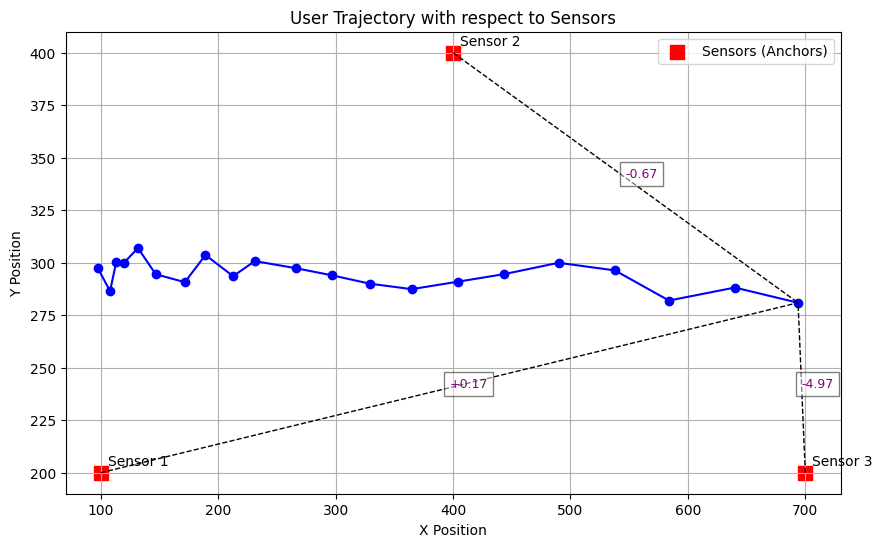

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import ConcreteModel, Var, Objective, SolverFactory, value, minimize
from matplotlib.animation import FuncAnimation, PillowWriter


# Fixed sensor positions (anchors)
sensors = np.array([
    [100, 200],
    [400, 400],
    [700, 200]
])

def estimate_position(distances):

    model = ConcreteModel()
    
    # Decision variables for the user's position
    model.x = Var(initialize=0)
    model.y = Var(initialize=0)
    
    # Objective function: sum of squared errors between calculated squared distances and measured squared distances.
    def objective_rule(m):
        return sum(((m.x - sensors[i][0])**2 + (m.y - sensors[i][1])**2 - distances[i]**2)**2 for i in range(3))
    model.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Solve the model using IPOPT solver.
    solver = SolverFactory('ipopt')
    solver.solve(model, tee=False)
    
    # Retrieve the solution values.
    x_est = value(model.x)
    y_est = value(model.y)
    
    return x_est, y_est

# Read the CSV file that contains the distance measurements.
data = pd.read_csv('distances.csv')

# Lists to store computed positions, timesteps, and measured distances
timesteps = []
x_positions = []
y_positions = []
anchor_measurements = [[], [], []]  # sensor 1,2,3 measurements

# Process each time step to estimate the user's position via trilateration.
for index, row in data.iterrows():
    timestep = row['t']
    measured_dists = [row['anchor_1'], row['anchor_2'], row['anchor_3']]
    x_est, y_est = estimate_position(measured_dists)
    timesteps.append(timestep)
    x_positions.append(x_est)
    y_positions.append(y_est)
    for i in range(3):
        anchor_measurements[i].append(measured_dists[i])
    print(f"Timestep {timestep}: Estimated Position = ({x_est:.2f}, {y_est:.2f})")


##########################################
# Plotting the trajectory

fig, ax = plt.subplots(figsize=(10, 6))

# Plot sensor positions (anchors)
sensor_x, sensor_y = zip(*sensors)
ax.scatter(sensor_x, sensor_y, color='red', marker='s', s=100, label='Sensors (Anchors)')
for i, (x_s, y_s) in enumerate(sensors, start=1):
    ax.annotate(f"Sensor {i}", (x_s, y_s), textcoords="offset points", xytext=(5, 5))

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('User Trajectory with respect to Sensors')
ax.legend()
ax.grid(True)

# Initialize plot elements
trajectory_line, = ax.plot([], [], 'b-o')

# Create three Line2D objects for error lines (one per sensor)
error_lines = [ax.plot([], [], 'k--', linewidth=1)[0] for _ in range(3)]

# Create three text objects for error annotation (one per sensor)
error_texts = [ax.text(0, 0, "", fontsize=9, color='purple', bbox=dict(facecolor='w', alpha=0.5)) for _ in range(3)]

# Initialization function for FuncAnimation
def init():
    trajectory_line.set_data([], [])
    for line in error_lines:
        line.set_data([], [])
    for txt in error_texts:
        txt.set_text("")
    return [trajectory_line] + error_lines + error_texts

# Animation update function: update trajectory, error lines, and annotations
def update(time_step):
    # Update trajectory line
    x_data = x_positions[:time_step+1]
    y_data = y_positions[:time_step+1]
    trajectory_line.set_data(x_data, y_data)
    
    # Get current estimated user position
    cur_x = x_positions[time_step]
    cur_y = y_positions[time_step]
    
    # Update error lines and annotations for each sensor
    for i in range(3):
        sensor_x, sensor_y = sensors[i]
        # Set error line data: from the sensor to the estimated user position
        error_lines[i].set_data([sensor_x, cur_x], [sensor_y, cur_y])
        
        # Compute Euclidean distance from the estimated position to sensor
        estimated_dist = math.sqrt((cur_x - sensor_x)**2 + (cur_y - sensor_y)**2)
        measured_dist = anchor_measurements[i][time_step]
        error_val = estimated_dist - measured_dist
        
        # Compute midpoint for annotation
        mid_x = (sensor_x + cur_x) / 2.0
        mid_y = (sensor_y + cur_y) / 2.0
        error_texts[i].set_position((mid_x, mid_y))
        error_texts[i].set_text(f"{error_val:+.2f}")
    
    return [trajectory_line] + error_lines + error_texts

# Create the animation with increased frame rate (10 frames per second)
num_frames = len(timesteps)
anim = FuncAnimation(fig, update, frames=num_frames, init_func=init, interval=100, blit=True)

# Save the animation as a GIF file
gif_filename = 'user_trajectory_with_errors.gif'
writer = PillowWriter(fps=3)
anim.save(gif_filename, writer=writer)

print(f"Animation saved as {gif_filename}")
plt.show()


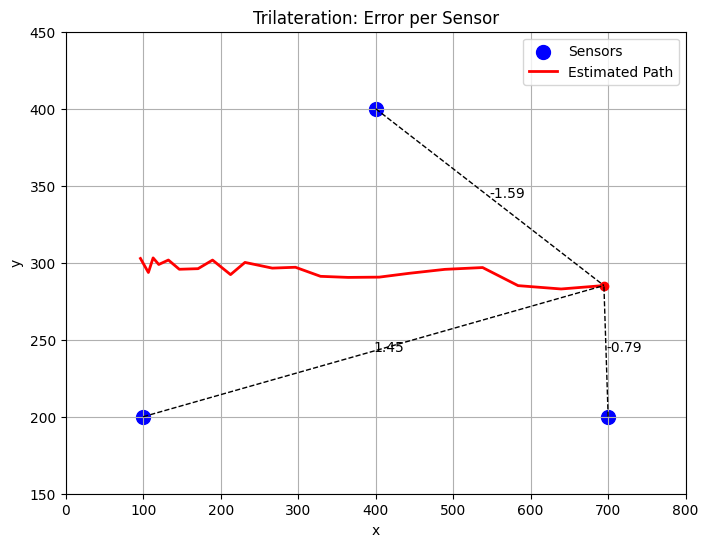

In [33]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load measured distances
df = pd.read_csv('distances.csv')
measured_values = df[['anchor_1', 'anchor_2', 'anchor_3']].values

# Define sensor locations
anchors = np.array([
    [100, 200],
    [400, 400],
    [700, 200]
])

# Trilateration objective
def trilateration_objective(xy, anchors, distances):
    return np.sum([(np.linalg.norm(xy - anchor) - dist) ** 2 for anchor, dist in zip(anchors, distances)])

# Estimate positions for all time steps
initial_guess = np.array([100.0, 200.0])
estimated_positions = []

for distances in measured_values:
    res = minimize(
        trilateration_objective,
        initial_guess,
        args=(anchors, distances),
        method='SLSQP',
        options={'ftol': 1e-6, 'disp': False}
    )
    if res.success:
        estimated_positions.append(res.x)
        initial_guess = res.x
    else:
        estimated_positions.append(initial_guess)

estimated_positions = np.array(estimated_positions)

# ----------------- Plot and Animation -----------------
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 800)
ax.set_ylim(150, 450)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Trilateration: Error per Sensor')
ax.grid(True)

# Static sensor plot
ax.scatter(anchors[:, 0], anchors[:, 1], c='blue', s=100, label='Sensors')

trajectory_line, = ax.plot([], [], 'r-', lw=2, label='Estimated Path')
current_point, = ax.plot([], [], 'ro', markersize=6)
error_lines = [ax.plot([], [], 'k--', lw=1)[0] for _ in anchors]
error_texts = [ax.text(0, 0, '', color='black') for _ in anchors]
ax.legend()

def init():
    trajectory_line.set_data([], [])
    current_point.set_data([], [])
    for line in error_lines:
        line.set_data([], [])
    for text in error_texts:
        text.set_text('')
    return [trajectory_line, current_point] + error_lines + error_texts

def update(frame):
    xy = estimated_positions[frame]
    trajectory_line.set_data(estimated_positions[:frame+1, 0], estimated_positions[:frame+1, 1])
    current_point.set_data([xy[0]], [xy[1]])

    for i, anchor in enumerate(anchors):
        ax_, ay_ = anchor
        x0, y0 = xy
        error_lines[i].set_data([ax_, x0], [ay_, y0])

        computed = np.linalg.norm(xy - anchor)
        measured = measured_values[frame, i]
        error = computed - measured

        mid_x = (ax_ + x0) / 2
        mid_y = (ay_ + y0) / 2
        error_texts[i].set_position((mid_x, mid_y))
        error_texts[i].set_text(f"{error:.2f}")

    fig.canvas.draw()  # Ensure canvas is updated per frame
    return [trajectory_line, current_point] + error_lines + error_texts

ani = animation.FuncAnimation(
    fig, update, frames=len(estimated_positions), init_func=init,
    blit=False, interval=100
)

# Save with PillowWriter
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=5)
ani.save("trilateration_error_animation.gif", writer=writer)

plt.show()
